In [37]:
import pandas as pd
from statsforecast import StatsForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.autonotebook import tqdm

In [38]:
from datetime import timedelta

def replace_outlier(x, upper, mx):
    if x > upper:
        return x * upper/mx
    else:
        return x

def subtract_days_from_date(date, days):    
    # subtracted_date = pd.to_datetime(date) - timedelta(days=days)
    subtracted_date = date - timedelta(days=days)
    subtracted_date = subtracted_date.strftime("%Y-%m-%d")

    return subtracted_date

def previous_average(df: pd.DataFrame):
    df.fillna(0, inplace=True)
    df_copy = df.copy()
    thresh = 0.8
    upper = df.quantile(thresh)
    
    for ind in df.index:
        today = pd.to_datetime(ind)
        date = pd.to_datetime(df.index)
        
        if df.loc[ind] > upper:
            prev_days = df.loc[(subtract_days_from_date(today, 56) <= pd.to_datetime(df.index)) & (pd.to_datetime(df.index) <= today) & (pd.to_datetime(df.index).weekday == today.day_of_week)]
            df_copy.loc[ind] = prev_days.quantile(thresh)

    return df_copy

    # for x in df:
    #     if x > df.quantile(0.8):
    #         prev_days = df[df.index.weekday == x.index.weekday]
    #         x = prev_days.mean()
    # return df

In [39]:
def expo_smoothing(name, original_dset, predict_step=14):
    # Fit the exponential smoothing model on the training data
    original_dset_copy = original_dset.copy()
    y_train, y_test = original_dset.iloc[:-predict_step, 0], original_dset.iloc[-predict_step:, 0]

    # Scale outliers
    # y_train = y_train.apply(lambda x: replace_outlier(x, y_train.quantile(0.85), y_train.max()))
    # y_train = previous_average(y_train)
    
    es_model = ExponentialSmoothing(y_train, trend=None, seasonal='additive', seasonal_periods=7)
    result = es_model.fit()

    # Get the forecasts for the test set
    y_pred = result.forecast(steps=len(y_test))

    # Plot the original data, forecasts, and test set
    plt.figure(figsize=(12, 3))
    plt.plot(original_dset_copy.index, original_dset_copy, label='Original Data')
    plt.plot(y_train.index, y_train, label='Scaled Data', color='orange')
    plt.plot(y_test.index, y_pred, label='Forecasts', color='red')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    plt.title(f"Name: {name}, R2 score: {r2_score(y_test, y_pred, force_finite=False)}")
    plt.show()


In [40]:
Y_df = pd.read_csv('../datasets/combined.csv')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.fillna(0, inplace=True)
Y_df.head()

,y,ds,unique_id
0,17.0,2020-01-02,H99
1,8.0,2020-01-03,H99
2,11.0,2020-01-06,H99
3,14.0,2020-01-07,H99
4,11.0,2020-01-08,H99


In [41]:
hosp_list = Y_df.unique_id.unique()
hosp_list

array(['H99', 'H89', 'H88', 'H43', 'H20', 'H16'], dtype=object)

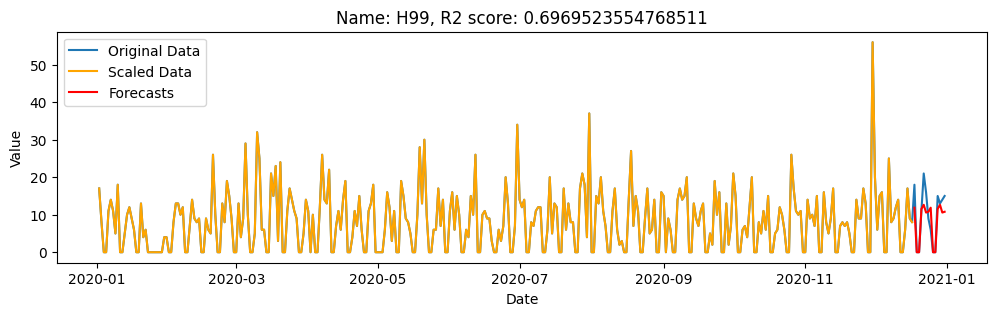

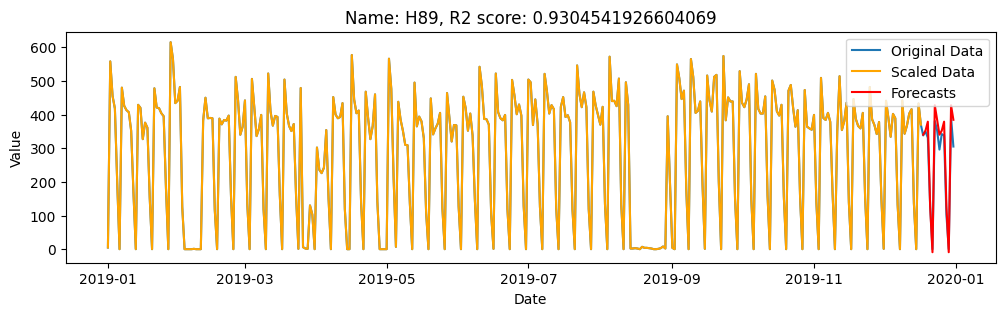

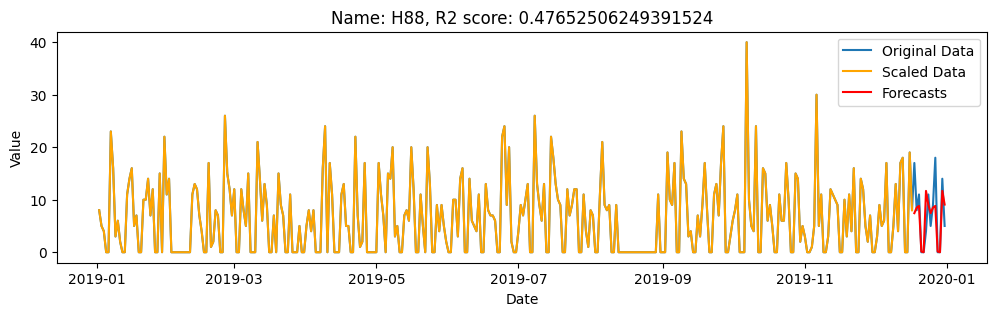

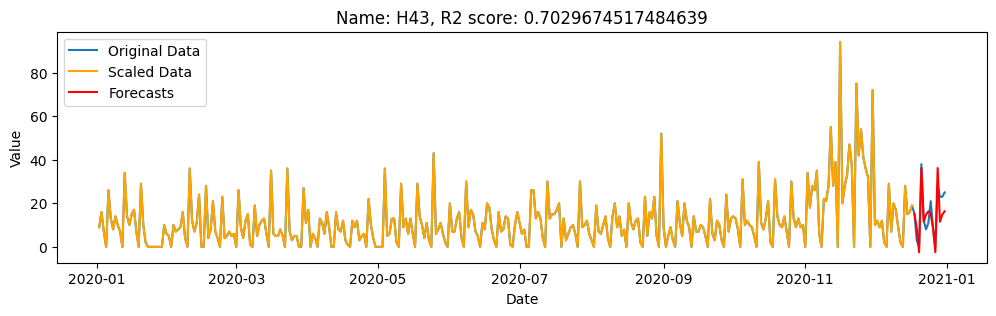

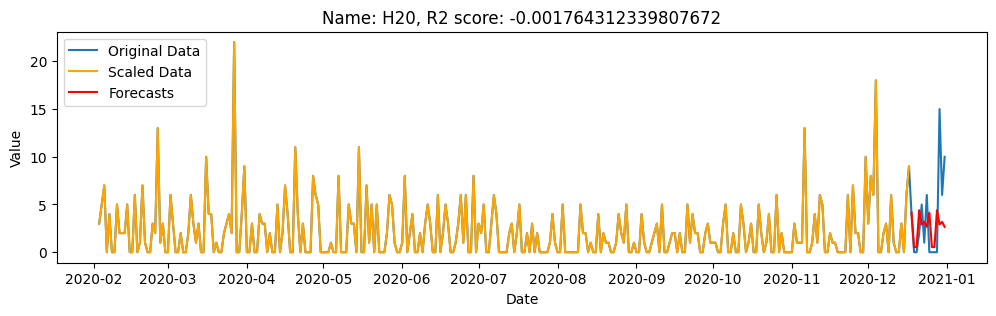

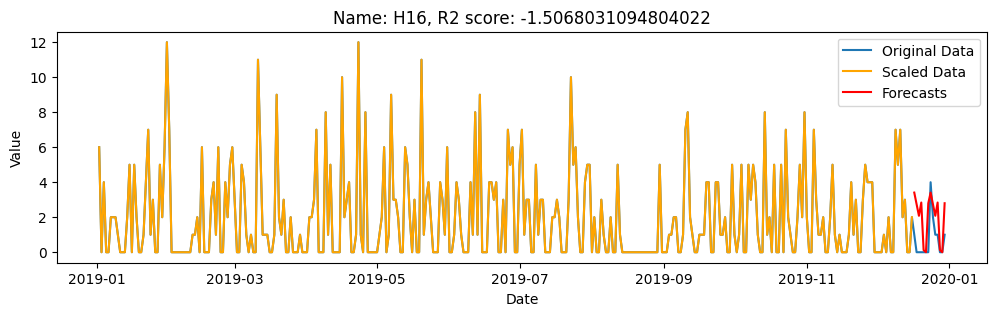

In [42]:
for hospital in hosp_list:
    es_df = Y_df.loc[Y_df['unique_id'] == hospital, :]
    es_df = es_df[['y', 'ds']]
    es_df.columns = ['volume', 'date']

    es_df['date'] = pd.to_datetime(es_df['date'])
    es_df = es_df[['date', 'volume']].set_index('date')
    es_df = es_df.asfreq('D')
    es_df.fillna(0, inplace=True)
    expo_smoothing(hospital, es_df, 14)
